In [ ]:
%matplotlib inline


# Text-to-speech with torchaudio

**Author**: [Yao-Yuan Yang](https://github.com/yangarbiter)_, [Moto
Hira](moto@fb.com)_


## Overview

This tutorial shows how to build text-to-speech pipeline, using the
pretrained Tacotron2 in torchaudio.

The text-to-speech pipeline goes as follows: 1. Text preprocessing

First, the input text is encoded into a list of symbols. In this
tutorial, we will use English characters and phonemes as the symbols.

2. Spectrogram generation

From the encoded text, a spectrogram is generated. We use ``Tacotron2``
model for this.

3. Time-domain conversion

The last step is converting the spectrogram into the waveform. The
process to generate speech from spectrogram is also called Vocoder. In
this tutorial, three different vocoders are used,
```WaveRNN`[](https://pytorch.org/audio/stable/models/wavernn.html)_,
```Griffin-Lim`[](https://pytorch.org/audio/stable/transforms.html#griffinlim)_,
and
```Nvidia's WaveGlow`[](https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/)_.

The following figure illustrates the whole process.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/tacotron2_tts_pipeline.png">




## Preparation

First, we install the necessary dependencies. In addition to
``torchaudio``, ``DeepPhonemizer`` is required to perform phoneme-based
encoding.




In [ ]:
%%bash
pip3 install deep_phonemizer

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt

import IPython

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

1.12.1+cu113
0.12.1+cu113


## Text Processing




### Character-based encoding

In this section, we will go through how the character-based encoding
works.

Since the pre-trained Tacotron2 model expects specific set of symbol
tables, the same functionalities available in ``torchaudio``. This
section is more for the explanation of the basis of encoding.

Firstly, we define the set of symbols. For example, we can use
``'_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'``. Then, we will map the
each character of the input text into the index of the corresponding
symbol in the table.

The following is an example of such processing. In the example, symbols
that are not in the table are ignored.




In [ ]:
symbols = '_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
  text = text.lower()
  return [look_up[s] for s in text if s in symbols]

text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


As mentioned in the above, the symbol table and indices must match
what the pretrained Tacotron2 model expects. ``torchaudio`` provides the
transform along with the pretrained model. For example, you can
instantiate and use such transform as follow.




In [ ]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


The ``processor`` object takes either a text or list of texts as inputs.
When a list of texts are provided, the returned ``lengths`` variable
represents the valid length of each processed tokens in the output
batch.

The intermediate representation can be retrieved as follow.




In [ ]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


### Phoneme-based encoding

Phoneme-based encoding is similar to character-based encoding, but it
uses a symbol table based on phonemes and a G2P (Grapheme-to-Phoneme)
model.

The detail of the G2P model is out of scope of this tutorial, we will
just look at what the conversion looks like.

Similar to the case of character-based encoding, the encoding process is
expected to match what a pretrained Tacotron2 model is trained on.
``torchaudio`` has an interface to create the process.

The following code illustrates how to make and use the process. Behind
the scene, a G2P model is created using ``DeepPhonemizer`` package, and
the pretrained weights published by the author of ``DeepPhonemizer`` is
fetched.




In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
  processed, lengths = processor(text)

print(processed)
print(lengths)

  0%|          | 0.00/63.6M [00:00<?, ?B/s]

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


Notice that the encoded values are different from the example of
character-based encoding.

The intermediate representation looks like the following.




In [ ]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


## Spectrogram Generation

``Tacotron2`` is the model we use to generate spectrogram from the
encoded text. For the detail of the model, please refer to [the
paper](https://arxiv.org/abs/1712.05884)_.

It is easy to instantiate a Tacotron2 model with pretrained weight,
however, note that the input to Tacotron2 models are processed by the
matching text processor.

``torchaudio`` bundles the matching models and processors together so
that it is easy to create the pipeline.

(For the available bundles, and its usage, please refer to [the
documentation](https://pytorch.org/audio/stable/pipelines.html#tacotron2-text-to-speech)_.)




Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

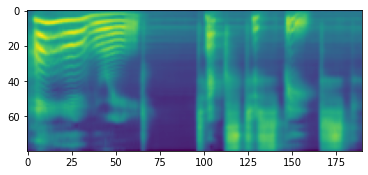

In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, _, _ = tacotron2.infer(processed, lengths)


plt.imshow(spec[0].cpu().detach())

Note that ``Tacotron2.infer`` method perfoms multinomial sampling,
therefor, the process of generating the spectrogram incurs randomness.




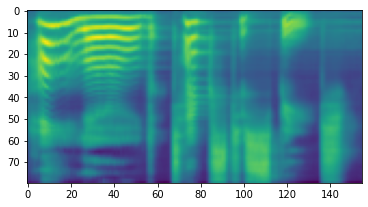

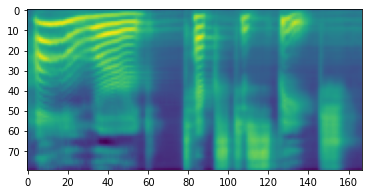

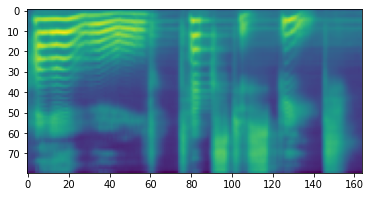

In [ ]:
for _ in range(3):
  with torch.inference_mode():
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  plt.imshow(spec[0].cpu().detach())
  plt.show()

## Waveform Generation

Once the spectrogram is generated, the last process is to recover the
waveform from the spectrogram.

``torchaudio`` provides vocoders based on ``GriffinLim`` and
``WaveRNN``.




### WaveRNN

Continuing from the previous section, we can instantiate the matching
WaveRNN model from the same bundle.




In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("output_wavernn.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_wavernn.wav"))

Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/wavernn_10k_epochs_8bits_ljspeech.pth


  0%|          | 0.00/16.7M [00:00<?, ?B/s]

### Griffin-Lim

Using the Griffin-Lim vocoder is same as WaveRNN. You can instantiate
the vocode object with ``get_vocoder`` method and pass the spectrogram.




In [ ]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("output_griffinlim.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_griffinlim.wav"))

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_phonemes_1500_epochs_ljspeech.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

### Waveglow

Waveglow is a vocoder published by Nvidia. The pretrained weights are
published on Torch Hub. One can instantiate the model using ``torch.hub``
module.




In [ ]:
if torch.cuda.is_available():
  waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp32')
else:
  # Workaround to load model mapped on GPU
  # https://stackoverflow.com/a/61840832
  waveglow = torch.hub.load(
      "NVIDIA/DeepLearningExamples:torchhub",
      "nvidia_waveglow",
      model_math="fp32",
      pretrained=False,
  )
  checkpoint = torch.hub.load_state_dict_from_url(
      "https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ckpt_fp32/versions/19.09.0/files/nvidia_waveglowpyt_fp32_20190427",
      progress=False,
      map_location=device,
  )
  state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
  waveforms = waveglow.infer(spec)

torchaudio.save("output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)
IPython.display.display(IPython.display.Audio("output_waveglow.wav"))